In [139]:
import numpy as np 
import matplotlib.pyplot as plt 
import glob 
from mumax_helper import * 
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
from glob import glob 
from numba import njit 
from scipy.stats import skewnorm

In [3]:
dir = "Twin Skyrmions f=50000000.0.out"
table = read_mumax3_table(dir+r"\table.txt")
arr = np.load(dir+r"\m.npz")
m = np.array([arr[key] for key in arr.keys()])

time_array = table['t']*1e9

In [78]:
# @njit
def trace_path(m_array):

    x_array = np.array([])
    y_array = np.array([])

    for time_step in m_array:

        # Very hacky: Guarentees all extremal points will be found in the same skyrmion
        # WARNING: Assumes the skyrmions initally lie along the x-axis
        if len(x_array) == 0:
            x_length = np.shape(time_step)[1]
            time_step = time_step[:, :int(x_length/2)] # cuts the image in half so only one skyrmion can be viewed

        y_coords, x_coords = np.unravel_index(
            np.argsort(time_step.ravel()), np.shape(time_step))

        if len(x_array) == 0:
            x_array = np.append(x_array, x_coords[0])
            y_array = np.append(y_array, y_coords[0])
        else:
            i = 0
            while np.sqrt((x_coords[i]-x_array[-1])**2 + (y_coords[i]-y_array[-1])**2) > 5:
                i += 1
            x_array = np.append(x_array, x_coords[i])
            y_array = np.append(y_array, y_coords[i])

    return np.array([x_array, y_array])

freq_list = []
avg_velocity_list = []

for dir in glob('*f=*.out'):


    freq = int(dir.split('=')[1].split('.')[0])

    if freq > 4e9:
        continue
    
    try:

        table = read_mumax3_table(dir+r"\table.txt")
        time_array = table['t']
        arr = np.load(dir+r"\m.npz")
        m = np.array([arr[key] for key in arr.keys()])

        mx_pos = m[:, 0, 0, :, :]
        my_pos = m[:, 1, 0, :, :]
        mx_neg = -m[:, 0, 0, :, :]
        my_neg = -m[:, 1, 0, :, :]


        mx_pos_path= trace_path(mx_pos)
        my_pos_path = trace_path(my_pos)
        mx_neg_path = trace_path(mx_neg)
        my_neg_path = trace_path(my_neg)

        extrema_coords = np.array([mx_pos_path, my_pos_path, mx_neg_path, my_neg_path])
        center_coord = np.mean(extrema_coords, axis=0)

        scale = 1e-9
        delta_t = np.diff(time_array)
        velocity_components = np.gradient(center_coord[:, 1:], delta_t[0], axis=1)*scale

        inst_velocity = np.sqrt(np.sum(velocity_components**2, axis=0))
        avg_velocity = np.mean(inst_velocity)

        freq_list.append(freq)
        avg_velocity_list.append(avg_velocity)
    except:
        pass


# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')


# plt.plot(time_array, center_coord[0], linewidth=1)
# plt.plot(time_array, center_coord[1], linewidth=1)
# plt.xlabel('Time')
# plt.ylabel('Pixel Value')

# plt.show()


In [149]:
skewnorm.pdf(sorted_freq,*skewnorm.fit(sorted_velocity))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [152]:
from scipy.integrate import quad


def integrand(t): 
    return 1/(2*np.pi) * np.exp(-t**2/2)

def skew_normal(x, xi, omega, alpha):

    upper_bound = alpha * (x - xi) / omega

    return 2/(omega*np.sqrt(2*np.pi)) * np.exp(-(x-xi)**2/(2*omega**2)) * quad(integrand, -np.inf, upper_bound)


skew_normal(1,1,1,1)



TypeError: can't multiply sequence by non-int of type 'numpy.float64'

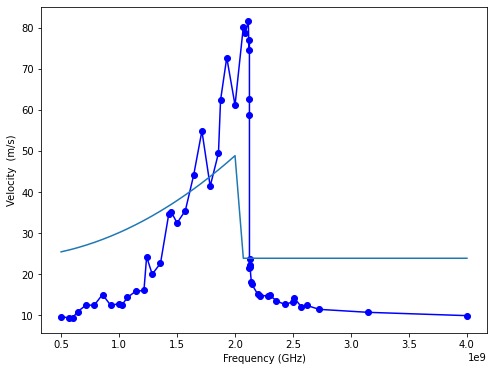

In [138]:
resonance_frequency = 2e9

# def quadratic_cutoff(frequency, A, B):

#     return (frequency <= resonance_frequency) * (A * frequency**2) + B

freq_list = np.array(freq_list)
avg_velocity_list = np.array(avg_velocity_list)
arg_list = np.argsort(freq_list)

sorted_freq = freq_list[arg_list]
sorted_velocity = avg_velocity_list[arg_list]

plt.figure(figsize=(8,6))

# popt, pocv = curve_fit(quadratic_cutoff, sorted_freq, sorted_velocity)
plt.plot(sorted_freq, sorted_velocity, "-o",color='blue')
# plt.axvline(x=1.638, color='grey', linestyle='--')
# plt.axvline(x=1.438, color='grey', linestyle='--')
plt.xlabel('Frequency (GHz)')
plt.ylabel("Velocity  (m/s)")
plt.plot(sorted_freq, *skewnorm.

# plt.plot(freq_list[arg_list], savgol_filter(avg_velocity_list[arg_list],5,3), "-")



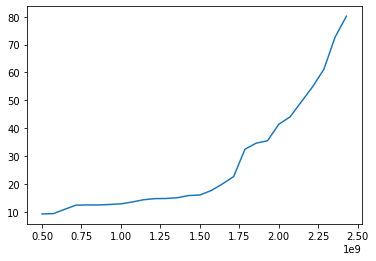

In [40]:
data_array = np.sort(np.stack((avg_velocity_list, freq_list),axis=-1),axis=0)
plt.plot(data_array[:,1],data_array[:,0])

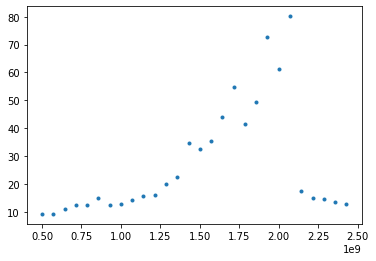

In [4]:
plt.plot(freq_list,avg_velocity_list,'.')
# plt.yscale('log')

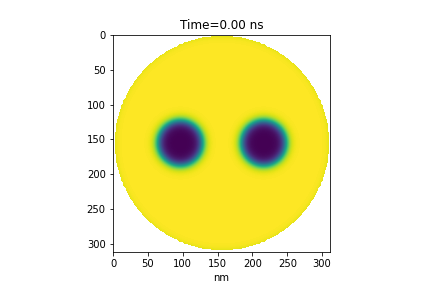

In [13]:
%matplotlib widget
mz_array = m[:, 2, 0, :, :]

# im = ax.imshow(mz_array[0])

### using this class is as easy as using FuncAnimation:

# Define initial parameters

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
# line, = ax.plot(center_coord[0, 0], center_coord[1, 0], 'r+')
im = plt.imshow(mz_array[0])
ax.set_xlabel('nm')
ax.set_title(f"Time={time_array[0]:.2f} ns")

# ax.set_title("blah")


def update(i):
    im.set_data(mz_array[i])
    # line.set_data(center_coord[0, :i], center_coord[1, :i])
    ax.set_title(f"Time={time_array[i]:.2f} ns")

    return
    # return line


ani = FuncAnimation(fig, update, interval=50, blit=False, save_count=1250, repeat=False)
# ani.save("Track Twin.mp4")

plt.show()


In [20]:
delta_t

array([2.00067981e-11, 2.00053679e-11, 1.99899353e-11, ...,
       1.99964023e-11, 1.99962611e-11, 1.99966555e-11])

In [23]:
np.gradient(center_coord[:,1:]*scale, delta_t[0], axis=1)

array([[ -0.10922861,  -0.13956989,  -0.20025245, ..., -46.48890866,
        -45.82140051, -45.48764643],
       [ -0.83741932,  -0.74639548,  -0.5643478 , ...,   5.87407174,
          1.50492747,  -0.67964466]])

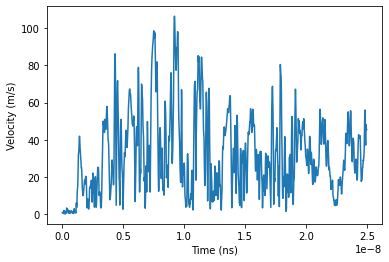

Average Velocity: 32.33082131571475 m/s


In [24]:
# x_array_in_nm = np.array(x_array) * 1e-9
# y_array_in_nm = np.array(y_array) * 1e-9

# time_spacing = np.gradient(time_array)

%matplotlib inline
scale = 200e-9 / 312
delta_t = np.diff(time_array)
velocity_components = np.gradient(center_coord[:,1:], delta_t[0], axis=1)*scale

inst_velocity = np.sqrt(np.sum(velocity_components**2,axis=0))
avg_velocity = np.mean(inst_velocity)


plt.plot(time_array[1:],inst_velocity)
plt.xlabel('Time (ns)')
plt.ylabel('Velocity (m/s)')
plt.show()

# rms = np.sqrt(np.mean(smooth_velocity**2))
print(f"Average Velocity: {avg_velocity} m/s")